# Random Forest Model on NSL-KDD

This notebook trains and evaluates a Random Forest classifier on the preprocessed NSL-KDD dataset.

## 1. Imports and setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

sns.set(style="whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


Matplotlib is building the font cache; this may take a moment.


## 2. Load preprocessed train / test data

In [4]:
X_train = np.load("../data/processed/X_train.npy")
X_test  = np.load("../data/processed/X_test.npy")
y_train = np.load("../data/processed/y_train.npy")
y_test  = np.load("../data/processed/y_test.npy")

X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")
y_train = y_train.astype("int32").ravel()
y_test  = y_test.astype("int32").ravel()

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test  shape:", y_test.shape)

n_features = X_train.shape[1]
print("Number of features:", n_features)

X_train shape: (125973, 41)
X_test  shape: (22544, 41)
y_train shape: (125973,)
y_test  shape: (22544,)
Number of features: 41


## 3. Train Random Forest classifier

In [5]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

print("Training Random Forest...")
rf.fit(X_train, y_train)
print("Random Forest trained.")

Training Random Forest...
Random Forest trained.


## 4. Evaluation on test set

In [6]:
# Predictions
y_pred_rf = rf.predict(X_test)

# Probabilities for the positive class (attack = 1) for ROC–AUC
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Compute metrics
acc_rf  = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf  = recall_score(y_test, y_pred_rf)
f1_rf   = f1_score(y_test, y_pred_rf)
auc_rf  = roc_auc_score(y_test, y_prob_rf)

print("=== Random Forest metrics on test set ===")
print(f"Accuracy : {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall   : {rec_rf:.4f}")
print(f"F1-score : {f1_rf:.4f}")
print(f"ROC-AUC  : {auc_rf:.4f}")

print("\nClassification report (0 = normal, 1 = attack):\n")
print(classification_report(y_test, y_pred_rf, target_names=["normal", "attack"]))

=== Random Forest metrics on test set ===
Accuracy : 0.7678
Precision: 0.9659
Recall   : 0.6137
F1-score : 0.7506
ROC-AUC  : 0.9704

Classification report (0 = normal, 1 = attack):

              precision    recall  f1-score   support

      normal       0.66      0.97      0.78      9711
      attack       0.97      0.61      0.75     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.79      0.77     22544
weighted avg       0.83      0.77      0.76     22544



## 5. Confusion matrix

Confusion matrix (Random Forest):
[[9433  278]
 [4957 7876]]


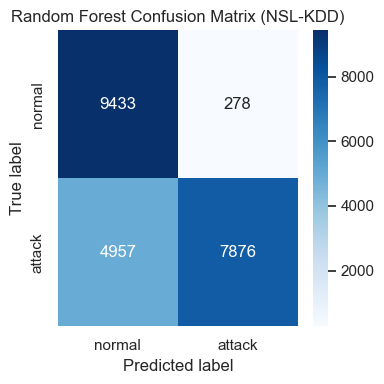

In [7]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion matrix (Random Forest):")
print(cm_rf)

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["normal", "attack"],
    yticklabels=["normal", "attack"],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Random Forest Confusion Matrix (NSL-KDD)")
plt.tight_layout()
plt.show()

## 6. Summary table of Random Forest performance

In [8]:
metrics_rf = pd.DataFrame(
    {
        "model": ["Random Forest"],
        "accuracy": [acc_rf],
        "precision": [prec_rf],
        "recall": [rec_rf],
        "f1": [f1_rf],
        "roc_auc": [auc_rf],
    }
)

metrics_rf

,model,accuracy,precision,recall,f1,roc_auc
0,Random Forest,0.767787,0.965906,0.61373,0.75056,0.970378


## 7. Save Random Forest metrics to CSV

In [9]:
import os

os.makedirs("../results", exist_ok=True)

try:
    metrics_rf
except NameError:
    metrics_rf = pd.DataFrame(
        {
            "model": ["Random Forest"],
            "accuracy": [acc_rf],
            "precision": [prec_rf],
            "recall": [rec_rf],
            "f1": [f1_rf],
            "roc_auc": [auc_rf],
        }
    )

metrics_path = "../results/random_forest_metrics.csv"
metrics_rf.to_csv(metrics_path, index=False)

print(f"Saved Random Forest metrics to {metrics_path}")
metrics_rf

Saved Random Forest metrics to ../results/random_forest_metrics.csv


,model,accuracy,precision,recall,f1,roc_auc
0,Random Forest,0.767787,0.965906,0.61373,0.75056,0.970378


## 8. Random Forest feature importance

Saved top-15 feature importances to ../results/random_forest_feature_importance_top15.csv


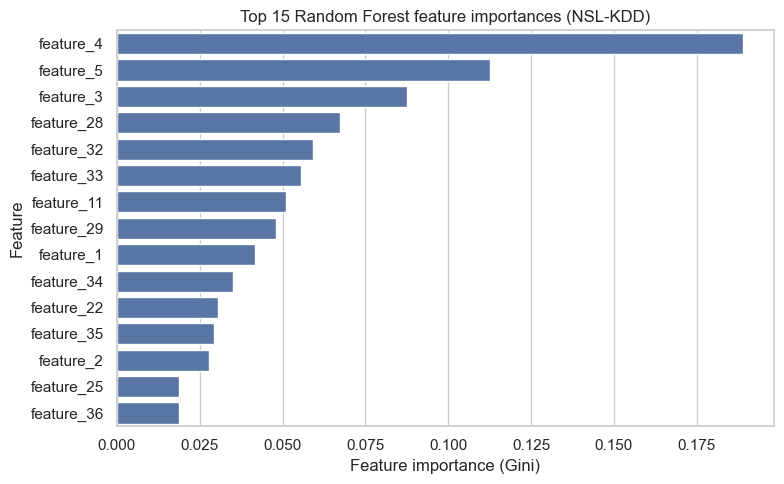

In [10]:
# Get feature importances from the trained Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 15  # number of top features to show
top_indices = indices[:top_k]

feature_labels = np.array([f"feature_{i}" for i in range(n_features)])[top_indices]

fi_df = pd.DataFrame(
    {
        "feature": feature_labels,
        "importance": importances[top_indices],
    }
)

fi_df

# Save feature importance to CSV
fi_path = "../results/random_forest_feature_importance_top15.csv"
fi_df.to_csv(fi_path, index=False)
print(f"Saved top-{top_k} feature importances to {fi_path}")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=fi_df,
    x="importance",
    y="feature",
)
plt.xlabel("Feature importance (Gini)")
plt.ylabel("Feature")
plt.title(f"Top {top_k} Random Forest feature importances (NSL-KDD)")
plt.tight_layout()
plt.show()